# Neural Network for Binary Classification of Stress
- There will be two classes: Stress and Rest. This is achieved by combining the S1 and S2 class into one class, Stress
- The neural network will only use the two signals from the breathing shirt: Chest Coil Signal and Abdomen Coil Signal.
- This neural network will use CNN layers, max pooling layers and a dense layer at the end before the output layer.

- Class imabalnce addressed by using class weights which improves the recall on the Rest class which sometimes does affectthe recall on the Stress class and therefore accuracy. 
- Tune hyperparamters: TODO

- Could remove S1 class all together? what if people were not too stressed out by trial 1 and it is causing some confusion with the Rest class?
- Could also try spectorgrams and 2d CNN 
- Maybe try adding LSTM layers for memory.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import scipy.signal
import heartpy as hp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [29]:
# Compilation Options
CLASS_WEIGHTS = True

In [30]:
# Specify the path to your CSV file
file_path = 'filtered_stress_data.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Specify the columns you want to extract
columns_to_extract = ['user_id', 'classification', 'chest_coil', 'abdomen_coil']
features = ['chest_coil', 'abdomen_coil']

# Extract the specified columns
extracted_columns = data[columns_to_extract]

# Drop any rows with missing data
extracted_columns = extracted_columns.dropna()

# Check for non-numeric values in each feature and replace them with NaNs
for feature in features:
    extracted_columns[feature] = pd.to_numeric(extracted_columns[feature], errors='coerce')

# Check if there are any NaNs in the dataset after replacing non-numeric values
if extracted_columns.isnull().values.any():
    print("NaNs detected after attempting to convert non-numeric values to float. Please check the data.")
    # Handle NaNs based on your requirements, such as removing rows with NaNs or imputing missing values
    # For this example, we will remove rows with NaNs
    extracted_columns = extracted_columns.dropna()

# Filter data 
extracted_columns['chest_coil'] = scipy.signal.detrend(extracted_columns['chest_coil'] )
extracted_columns['chest_coil']  = hp.filter_signal(extracted_columns['chest_coil'] , cutoff=1, sample_rate=20.0, filtertype='lowpass', return_top=False)

extracted_columns['abdomen_coil']  = scipy.signal.detrend(extracted_columns['abdomen_coil'] )
extracted_columns['abdomen_coil']  = hp.filter_signal(extracted_columns['abdomen_coil'] , cutoff=1, sample_rate=20.0, filtertype='lowpass', return_top=False)

print(extracted_columns["abdomen_coil"].shape)
print(extracted_columns["chest_coil"].shape)

# Ensure we are using the cleaned data for further processing
data = extracted_columns

# Combine S1 and S2 classes into one "Stress" class
data['classification'] = data['classification'].replace({'S1': 'Stress', 'S2': 'Stress'})

print(data['classification'].value_counts())
print(data['classification'].unique())

NaNs detected after attempting to convert non-numeric values to float. Please check the data.
(186614,)
(186614,)
classification
Stress    124762
Rest       61852
Name: count, dtype: int64
['Rest' 'Stress']


In [31]:
# Feature Extraction
# Extract features and labels
X = data[['chest_coil', 'abdomen_coil']].values
y = data['classification'].values
user_ids = data['user_id'].values

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(label_encoder.classes_)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data into sequences
time_step_length = 100  # Define your sequence length
num_samples = len(X_scaled) // time_step_length

X_sequences = np.array([X_scaled[i*time_step_length:(i+1)*time_step_length] for i in range(num_samples)])
y_sequences = np.array([y[i*time_step_length] for i in range(num_samples)])
user_id_sequences = np.array([user_ids[i*time_step_length] for i in range(num_samples)])

['Rest' 'Stress']


In [32]:
# Split the data into training and testing sets based on user_id to avoid data leakage
gkf = GroupKFold(n_splits=5)
for train_index, test_index in gkf.split(X_sequences, y_sequences, groups=user_id_sequences):
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    break  # Use the first split

# Check the shape of the reshaped data
print(X_train.shape)  # Should be (num_samples, time_step_length, num_features)
print(X_test.shape)

(1478, 100, 2)
(388, 100, 2)


In [33]:
# Compute class weights
if CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

In [34]:
# Define the objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    num_filters = trial.suggest_int('num_filters', 16, 128, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    
    model = Sequential()
    model.add(Conv1D(num_filters, 3, activation='relu', input_shape=(time_step_length, X_train.shape[2])))
    model.add(MaxPooling1D(2))
    for _ in range(num_layers - 1):
        model.add(Conv1D(num_filters, 3, activation='relu'))
        model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with Adam optimizer and learning rate scheduler
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks for learning rate adjustment and early stopping
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    if CLASS_WEIGHTS:
        # Train the model with class weights
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                            class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
    else:
        # Train the model without class weights 
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[lr_reduction, early_stopping])

    score = model.evaluate(X_test, y_test, verbose=0)

    return score[1]

In [35]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Retrieve best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

[I 2024-05-23 22:45:34,646] A new study created in memory with name: no-name-fec33514-66c3-423f-b173-c29574f0d560


Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6093 - loss: 0.6776 - val_accuracy: 0.2345 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6926 - loss: 0.6160 - val_accuracy: 0.1521 - val_loss: 1.3738 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7204 - loss: 0.5538 - val_accuracy: 0.1727 - val_loss: 1.5843 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7329 - loss: 0.4724 - val_accuracy: 0.2680 - val_loss: 3.5654 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7215 - loss: 0.4741 - val_accuracy: 0.2526 - val_loss: 3.2377 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7670 - loss: 0.4182 - val_accuracy: 0.5052 - val_loss: 4.3152 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7820 - loss: 0.4034 - val_accuracy: 0

[I 2024-05-23 22:45:40,959] Trial 0 finished with value: 0.2345360815525055 and parameters: {'learning_rate': 0.027522895517384505, 'dropout_rate': 0.39500511414676887, 'num_filters': 85, 'num_layers': 3}. Best is trial 0 with value: 0.2345360815525055.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5831 - loss: 0.6719 - val_accuracy: 0.3376 - val_loss: 1.0767 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6803 - loss: 0.5813 - val_accuracy: 0.2268 - val_loss: 1.4095 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7122 - loss: 0.5257 - val_accuracy: 0.2216 - val_loss: 1.6798 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6867 - loss: 0.5176 - val_accuracy: 0.4124 - val_loss: 1.9891 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7430 - loss: 0.4769 - val_accuracy: 0.4278 - val_loss: 2.4279 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7679 - loss: 0.4627 - val_accuracy: 0.4665 - val_loss: 2.5430 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7437 - loss: 0.4612 - val_ac

[I 2024-05-23 22:45:45,347] Trial 1 finished with value: 0.33762887120246887 and parameters: {'learning_rate': 0.01311263686098672, 'dropout_rate': 0.18646998867658338, 'num_filters': 41, 'num_layers': 1}. Best is trial 1 with value: 0.33762887120246887.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6226 - loss: 0.6918 - val_accuracy: 0.1289 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6350 - loss: 0.6349 - val_accuracy: 0.2861 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6993 - loss: 0.5834 - val_accuracy: 0.2655 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6917 - loss: 0.5720 - val_accuracy: 0.4253 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7039 - loss: 0.5896 - val_accuracy: 0.3325 - val_loss: 1.2282 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7176 - loss: 0.5299 - val_accuracy: 0.4665 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7171 - loss: 0.5153 - val_accur

[I 2024-05-23 22:45:53,859] Trial 2 finished with value: 0.42525774240493774 and parameters: {'learning_rate': 0.028765463763429876, 'dropout_rate': 0.4812984469865008, 'num_filters': 65, 'num_layers': 1}. Best is trial 2 with value: 0.42525774240493774.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5534 - loss: 0.6843 - val_accuracy: 0.3067 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7020 - loss: 0.5846 - val_accuracy: 0.4098 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6890 - loss: 0.5491 - val_accuracy: 0.4046 - val_loss: 1.3901 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7035 - loss: 0.5170 - val_accuracy: 0.3943 - val_loss: 2.1961 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7273 - loss: 0.4539 - val_accuracy: 0.3299 - val_loss: 2.7756 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7124 - loss: 0.4473 - val_accuracy: 0.3376 - val_loss: 3.4648 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6929 - loss: 0.4576 - va

[I 2024-05-23 22:46:00,677] Trial 3 finished with value: 0.30670103430747986 and parameters: {'learning_rate': 0.00011261260808444785, 'dropout_rate': 0.45019595228559467, 'num_filters': 38, 'num_layers': 3}. Best is trial 2 with value: 0.42525774240493774.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5966 - loss: 0.6592 - val_accuracy: 0.2474 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7386 - loss: 0.5597 - val_accuracy: 0.1675 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7234 - loss: 0.5256 - val_accuracy: 0.2216 - val_loss: 1.1883 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7126 - loss: 0.5043 - val_accuracy: 0.4716 - val_loss: 1.7285 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7458 - loss: 0.4731 - val_accuracy: 0.4871 - val_loss: 2.0844 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7665 - loss: 0.4562 - val_accuracy: 0.4665 - val_loss: 2.2261 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7860 - loss: 0.4302 - val_

[I 2024-05-23 22:46:07,136] Trial 4 finished with value: 0.24742268025875092 and parameters: {'learning_rate': 0.03696147487772515, 'dropout_rate': 0.2503039540917944, 'num_filters': 47, 'num_layers': 2}. Best is trial 2 with value: 0.42525774240493774.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5379 - loss: 0.6688 - val_accuracy: 0.2139 - val_loss: 1.2924 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7183 - loss: 0.5661 - val_accuracy: 0.1959 - val_loss: 1.1892 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7035 - loss: 0.5332 - val_accuracy: 0.1804 - val_loss: 1.9845 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7091 - loss: 0.5033 - val_accuracy: 0.1985 - val_loss: 1.7690 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6802 - loss: 0.4838 - val_accuracy: 0.0876 - val_loss: 2.7509 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7143 - loss: 0.4500 - val_accuracy: 0.5670 - val_loss: 2.5404 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7401 - loss: 0.4780 - val_accur

[I 2024-05-23 22:46:14,324] Trial 5 finished with value: 0.19587628543376923 and parameters: {'learning_rate': 7.085816087334675e-05, 'dropout_rate': 0.19084011106669596, 'num_filters': 39, 'num_layers': 3}. Best is trial 2 with value: 0.42525774240493774.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6044 - loss: 0.6588 - val_accuracy: 0.2964 - val_loss: 1.0678 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7088 - loss: 0.5661 - val_accuracy: 0.4794 - val_loss: 1.0168 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7670 - loss: 0.5043 - val_accuracy: 0.4227 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7204 - loss: 0.5063 - val_accuracy: 0.4356 - val_loss: 1.6879 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7289 - loss: 0.4793 - val_accuracy: 0.5206 - val_loss: 2.2494 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7764 - loss: 0.4573 - val_accuracy: 0.5000 - val_loss: 2.4608 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7643 - loss: 0.4354 - val_accur

[I 2024-05-23 22:46:22,034] Trial 6 finished with value: 0.4793814420700073 and parameters: {'learning_rate': 2.4820559279440586e-05, 'dropout_rate': 0.28041929062996757, 'num_filters': 47, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6760 - loss: 0.6226 - val_accuracy: 0.1907 - val_loss: 1.1303 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7254 - loss: 0.5386 - val_accuracy: 0.1624 - val_loss: 1.2748 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7130 - loss: 0.5142 - val_accuracy: 0.2242 - val_loss: 1.2858 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7747 - loss: 0.4638 - val_accuracy: 0.4562 - val_loss: 1.5116 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7806 - loss: 0.4457 - val_accuracy: 0.4278 - val_loss: 1.8030 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7761 - loss: 0.4410 - val_accuracy: 0.5902 - val_loss: 1.8789 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8147 - loss: 0.3976 - val_a

[I 2024-05-23 22:46:27,619] Trial 7 finished with value: 0.19072164595127106 and parameters: {'learning_rate': 0.006430758371956803, 'dropout_rate': 0.02240914258097404, 'num_filters': 27, 'num_layers': 1}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6095 - loss: 0.6693 - val_accuracy: 0.2036 - val_loss: 1.3980 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7016 - loss: 0.5743 - val_accuracy: 0.1314 - val_loss: 1.2771 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7226 - loss: 0.5080 - val_accuracy: 0.1521 - val_loss: 1.9998 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6911 - loss: 0.4836 - val_accuracy: 0.2655 - val_loss: 1.8930 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7453 - loss: 0.4420 - val_accuracy: 0.2706 - val_loss: 2.5342 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7284 - loss: 0.4322 - val_accuracy: 0.2577 - val_loss: 4.0683 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7588 - loss: 0.4080 - val_a

[I 2024-05-23 22:46:36,540] Trial 8 finished with value: 0.13144329190254211 and parameters: {'learning_rate': 0.03457922190445281, 'dropout_rate': 0.34295079576358894, 'num_filters': 72, 'num_layers': 3}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6566 - loss: 0.6403 - val_accuracy: 0.4175 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6831 - loss: 0.5704 - val_accuracy: 0.4639 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7061 - loss: 0.5485 - val_accuracy: 0.4665 - val_loss: 1.1034 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7347 - loss: 0.5079 - val_accuracy: 0.4459 - val_loss: 1.2312 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7077 - loss: 0.4922 - val_accuracy: 0.4768 - val_loss: 1.4570 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7661 - loss: 0.4593 - val_accuracy: 0.3711 - val_loss: 1.5876 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6981 - loss: 0.4693 - val_a

[I 2024-05-23 22:46:43,313] Trial 9 finished with value: 0.4175257682800293 and parameters: {'learning_rate': 0.0001637615752618842, 'dropout_rate': 0.21634830642962893, 'num_filters': 19, 'num_layers': 1}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6098 - loss: 0.6396 - val_accuracy: 0.2242 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7026 - loss: 0.5442 - val_accuracy: 0.4227 - val_loss: 1.2695 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7839 - loss: 0.4882 - val_accuracy: 0.3196 - val_loss: 1.8765 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7108 - loss: 0.4976 - val_accuracy: 0.4536 - val_loss: 2.4256 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7782 - loss: 0.4445 - val_accuracy: 0.4485 - val_loss: 2.8190 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8091 - loss: 0.4006 - val_accuracy: 0.3479 - val_loss: 2.6568 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8134 - loss: 0.3871 -

[I 2024-05-23 22:46:53,523] Trial 10 finished with value: 0.22422680258750916 and parameters: {'learning_rate': 2.1062344346150605e-05, 'dropout_rate': 0.06119591520254075, 'num_filters': 116, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5755 - loss: 0.6757 - val_accuracy: 0.1907 - val_loss: 1.0187 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6815 - loss: 0.6041 - val_accuracy: 0.2345 - val_loss: 1.2227 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7043 - loss: 0.5528 - val_accuracy: 0.2216 - val_loss: 1.3435 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7021 - loss: 0.5193 - val_accuracy: 0.4381 - val_loss: 1.3292 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7304 - loss: 0.4997 - val_accuracy: 0.5515 - val_loss: 1.4825 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7719 - loss: 0.4524 - val_accuracy: 0.4794 - val_loss: 1.7434 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7419 - loss: 0.4750 - val_

[I 2024-05-23 22:47:00,815] Trial 11 finished with value: 0.19072164595127106 and parameters: {'learning_rate': 0.0015304496834390013, 'dropout_rate': 0.48688783970939065, 'num_filters': 61, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5849 - loss: 0.6633 - val_accuracy: 0.3531 - val_loss: 1.1046 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6872 - loss: 0.5916 - val_accuracy: 0.2165 - val_loss: 1.0873 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6794 - loss: 0.5880 - val_accuracy: 0.3892 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7051 - loss: 0.5600 - val_accuracy: 0.1263 - val_loss: 1.0493 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6848 - loss: 0.5375 - val_accuracy: 0.4098 - val_loss: 1.4105 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7385 - loss: 0.5025 - val_accuracy: 0.4459 - val_loss: 1.6274 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6911 - loss: 0.5145 - val_accura

[I 2024-05-23 22:47:09,245] Trial 12 finished with value: 0.12628865242004395 and parameters: {'learning_rate': 0.0013973330068700442, 'dropout_rate': 0.31740174329920756, 'num_filters': 58, 'num_layers': 1}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6721 - loss: 0.6201 - val_accuracy: 0.4510 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7521 - loss: 0.5312 - val_accuracy: 0.5412 - val_loss: 1.1161 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7070 - loss: 0.5103 - val_accuracy: 0.3763 - val_loss: 2.7419 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6878 - loss: 0.4640 - val_accuracy: 0.5335 - val_loss: 3.4677 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7093 - loss: 0.4425 - val_accuracy: 0.4278 - val_loss: 3.9256 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7686 - loss: 0.3981 - val_accuracy: 0.5129 - val_loss: 4.1554 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7821 - loss: 0.3808 -

[I 2024-05-23 22:47:18,985] Trial 13 finished with value: 0.4510309398174286 and parameters: {'learning_rate': 1.7617025166978288e-05, 'dropout_rate': 0.11043146783369406, 'num_filters': 105, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6288 - loss: 0.6357 - val_accuracy: 0.3969 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7265 - loss: 0.5141 - val_accuracy: 0.4639 - val_loss: 1.4780 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7284 - loss: 0.4778 - val_accuracy: 0.4227 - val_loss: 2.5093 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7305 - loss: 0.4708 - val_accuracy: 0.2268 - val_loss: 3.5479 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7463 - loss: 0.4027 - val_accuracy: 0.3093 - val_loss: 3.7519 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7903 - loss: 0.3753 - val_accuracy: 0.4639 - val_loss: 4.1926 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8011 - loss: 0.3608 -

[I 2024-05-23 22:47:29,101] Trial 14 finished with value: 0.3969072103500366 and parameters: {'learning_rate': 1.2211652050761157e-05, 'dropout_rate': 0.10790765033487663, 'num_filters': 124, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6392 - loss: 0.6384 - val_accuracy: 0.4459 - val_loss: 0.8952 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6898 - loss: 0.5632 - val_accuracy: 0.4149 - val_loss: 1.2716 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7327 - loss: 0.5302 - val_accuracy: 0.4253 - val_loss: 1.5108 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7676 - loss: 0.4816 - val_accuracy: 0.2938 - val_loss: 1.4816 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7295 - loss: 0.4789 - val_accuracy: 0.3814 - val_loss: 2.2060 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7864 - loss: 0.4192 - val_accuracy: 0.2577 - val_loss: 2.2598 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7613 - loss: 0.4098 -

[I 2024-05-23 22:47:38,077] Trial 15 finished with value: 0.4458763003349304 and parameters: {'learning_rate': 0.0003289500946869617, 'dropout_rate': 0.12021306832324602, 'num_filters': 93, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5153 - loss: 0.6761 - val_accuracy: 0.4253 - val_loss: 0.9236 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7034 - loss: 0.5918 - val_accuracy: 0.2191 - val_loss: 1.1349 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7112 - loss: 0.5674 - val_accuracy: 0.2345 - val_loss: 1.1567 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7350 - loss: 0.5332 - val_accuracy: 0.4820 - val_loss: 1.1144 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7645 - loss: 0.5217 - val_accuracy: 0.4253 - val_loss: 1.3099 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7639 - loss: 0.4758 - val_accuracy: 0.4227 - val_loss: 1.4716 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7070 - loss: 0.4865 - val_a

[I 2024-05-23 22:47:43,976] Trial 16 finished with value: 0.42525774240493774 and parameters: {'learning_rate': 3.1548070999699226e-05, 'dropout_rate': 0.2686058032665705, 'num_filters': 16, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6299 - loss: 0.6273 - val_accuracy: 0.3041 - val_loss: 0.9346 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7118 - loss: 0.5383 - val_accuracy: 0.4356 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7642 - loss: 0.4951 - val_accuracy: 0.5309 - val_loss: 1.5151 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7440 - loss: 0.4817 - val_accuracy: 0.5464 - val_loss: 2.2545 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7633 - loss: 0.4503 - val_accuracy: 0.5180 - val_loss: 2.5242 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7188 - loss: 0.4619 - val_accuracy: 0.5000 - val_loss: 3.2324 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7692 - loss: 0.4183 - val_a

[I 2024-05-23 22:47:50,890] Trial 17 finished with value: 0.3041236996650696 and parameters: {'learning_rate': 0.00037798214522627037, 'dropout_rate': 0.13427006161490027, 'num_filters': 27, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6271 - loss: 0.6658 - val_accuracy: 0.1546 - val_loss: 1.1790 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6664 - loss: 0.5927 - val_accuracy: 0.1907 - val_loss: 1.5149 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7053 - loss: 0.5230 - val_accuracy: 0.1546 - val_loss: 1.6038 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7226 - loss: 0.5027 - val_accuracy: 0.2706 - val_loss: 2.3539 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6667 - loss: 0.4861 - val_accuracy: 0.2706 - val_loss: 2.7879 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6708 - loss: 0.4805 - val_accuracy: 0.3789 - val_loss: 2.9879 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7082 - loss: 0.4304 - val_a

[I 2024-05-23 22:47:56,833] Trial 18 finished with value: 0.15463916957378387 and parameters: {'learning_rate': 4.1214210913311686e-05, 'dropout_rate': 0.31000002547556865, 'num_filters': 27, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6505 - loss: 0.6298 - val_accuracy: 0.2216 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6930 - loss: 0.5292 - val_accuracy: 0.4768 - val_loss: 1.9239 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7349 - loss: 0.4950 - val_accuracy: 0.2371 - val_loss: 3.4590 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7079 - loss: 0.4392 - val_accuracy: 0.4278 - val_loss: 4.3780 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7669 - loss: 0.3877 - val_accuracy: 0.2938 - val_loss: 5.6977 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7871 - loss: 0.3632 - val_accuracy: 0.3686 - val_loss: 4.9929 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8046 - loss: 0.3157 -

[I 2024-05-23 22:48:06,754] Trial 19 finished with value: 0.22164948284626007 and parameters: {'learning_rate': 1.1091388965342988e-05, 'dropout_rate': 0.008176933057748262, 'num_filters': 101, 'num_layers': 3}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6590 - loss: 0.6489 - val_accuracy: 0.4330 - val_loss: 1.0667 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6944 - loss: 0.5494 - val_accuracy: 0.4588 - val_loss: 1.4370 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7090 - loss: 0.4957 - val_accuracy: 0.4845 - val_loss: 2.6090 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7150 - loss: 0.4676 - val_accuracy: 0.4356 - val_loss: 3.2918 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7407 - loss: 0.4143 - val_accuracy: 0.4923 - val_loss: 4.0476 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7287 - loss: 0.4137 - val_accuracy: 0.4923 - val_loss: 3.8074 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7593 - loss: 0.3934 - val_a

[I 2024-05-23 22:48:13,621] Trial 20 finished with value: 0.4329896867275238 and parameters: {'learning_rate': 0.00046893164692144096, 'dropout_rate': 0.14626670609385997, 'num_filters': 50, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6046 - loss: 0.6454 - val_accuracy: 0.4278 - val_loss: 0.8935 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7312 - loss: 0.5471 - val_accuracy: 0.4381 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7537 - loss: 0.5026 - val_accuracy: 0.5567 - val_loss: 1.4354 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7435 - loss: 0.4586 - val_accuracy: 0.5000 - val_loss: 1.7661 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7260 - loss: 0.4741 - val_accuracy: 0.4510 - val_loss: 3.5162 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7532 - loss: 0.4299 - val_accuracy: 0.3969 - val_loss: 4.6354 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7752 - loss: 0.4027 - 

[I 2024-05-23 22:48:23,001] Trial 21 finished with value: 0.42783504724502563 and parameters: {'learning_rate': 0.0002569815347668672, 'dropout_rate': 0.1048552925710913, 'num_filters': 93, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6177 - loss: 0.6356 - val_accuracy: 0.2268 - val_loss: 0.9843 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7161 - loss: 0.5427 - val_accuracy: 0.2139 - val_loss: 1.3899 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6954 - loss: 0.5405 - val_accuracy: 0.2732 - val_loss: 1.6890 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7276 - loss: 0.4876 - val_accuracy: 0.4381 - val_loss: 2.4362 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7673 - loss: 0.4526 - val_accuracy: 0.1856 - val_loss: 2.7023 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7599 - loss: 0.4201 - val_accuracy: 0.4485 - val_loss: 2.9130 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7668 - loss: 0.4132 - v

[I 2024-05-23 22:48:31,421] Trial 22 finished with value: 0.22680412232875824 and parameters: {'learning_rate': 5.967374129395e-05, 'dropout_rate': 0.06112750841314848, 'num_filters': 79, 'num_layers': 2}. Best is trial 6 with value: 0.4793814420700073.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6238 - loss: 0.6298 - val_accuracy: 0.4639 - val_loss: 1.2036 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7205 - loss: 0.5388 - val_accuracy: 0.5103 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6736 - loss: 0.5385 - val_accuracy: 0.5180 - val_loss: 2.4131 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7550 - loss: 0.4853 - val_accuracy: 0.2423 - val_loss: 3.5014 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6910 - loss: 0.4652 - val_accuracy: 0.4665 - val_loss: 4.4150 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7187 - loss: 0.4420 - val_accuracy: 0.4948 - val_loss: 4.0700 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7595 - loss: 0.3991 - val

[I 2024-05-23 22:48:41,431] Trial 23 finished with value: 0.5103092789649963 and parameters: {'learning_rate': 0.003336057634006308, 'dropout_rate': 0.20615810309352567, 'num_filters': 109, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5977 - loss: 0.6517 - val_accuracy: 0.2680 - val_loss: 0.9905 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7214 - loss: 0.5660 - val_accuracy: 0.2216 - val_loss: 1.6339 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6888 - loss: 0.5429 - val_accuracy: 0.1933 - val_loss: 2.2207 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6989 - loss: 0.5142 - val_accuracy: 0.2165 - val_loss: 3.2343 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7306 - loss: 0.4650 - val_accuracy: 0.4845 - val_loss: 3.4094 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7769 - loss: 0.4269 - val_accuracy: 0.4897 - val_loss: 4.1144 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7633 - loss: 0.4283 -

[I 2024-05-23 22:48:51,188] Trial 24 finished with value: 0.2680412232875824 and parameters: {'learning_rate': 0.0035744118279589627, 'dropout_rate': 0.21357847271956582, 'num_filters': 109, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6475 - loss: 0.6403 - val_accuracy: 0.2088 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7171 - loss: 0.5638 - val_accuracy: 0.2268 - val_loss: 1.7342 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7036 - loss: 0.5242 - val_accuracy: 0.1598 - val_loss: 2.1219 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6735 - loss: 0.5232 - val_accuracy: 0.2216 - val_loss: 2.2713 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6605 - loss: 0.5039 - val_accuracy: 0.2629 - val_loss: 2.7867 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6867 - loss: 0.4682 - val_accuracy: 0.2397 - val_loss: 2.9730 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7239 - loss: 0.4349 - val_a

[I 2024-05-23 22:48:57,774] Trial 25 finished with value: 0.20876288414001465 and parameters: {'learning_rate': 0.0008370521261236292, 'dropout_rate': 0.2836150411840444, 'num_filters': 31, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5642 - loss: 0.6867 - val_accuracy: 0.2294 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6816 - loss: 0.6055 - val_accuracy: 0.2294 - val_loss: 1.1007 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7017 - loss: 0.5735 - val_accuracy: 0.2655 - val_loss: 1.3610 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7271 - loss: 0.5444 - val_accuracy: 0.4459 - val_loss: 1.7018 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7278 - loss: 0.5000 - val_accuracy: 0.4278 - val_loss: 1.8330 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7094 - loss: 0.4808 - val_accuracy: 0.4510 - val_loss: 1.9009 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7040 - loss: 0.5030 -

[I 2024-05-23 22:49:06,687] Trial 26 finished with value: 0.22938144207000732 and parameters: {'learning_rate': 0.0037421484598016575, 'dropout_rate': 0.3731760382063254, 'num_filters': 125, 'num_layers': 1}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6554 - loss: 0.6498 - val_accuracy: 0.3789 - val_loss: 0.9091 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7303 - loss: 0.5438 - val_accuracy: 0.4175 - val_loss: 0.9054 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7704 - loss: 0.5169 - val_accuracy: 0.4665 - val_loss: 1.2699 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7613 - loss: 0.5072 - val_accuracy: 0.2732 - val_loss: 0.9383 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6421 - loss: 0.5285 - val_accuracy: 0.4510 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7508 - loss: 0.4431 - val_accuracy: 0.2835 - val_loss: 1.4454 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6936 - loss: 0.4629 - val

[I 2024-05-23 22:49:15,883] Trial 27 finished with value: 0.4175257682800293 and parameters: {'learning_rate': 2.1023566587427263e-05, 'dropout_rate': 0.17204960207451517, 'num_filters': 72, 'num_layers': 3}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6289 - loss: 0.6533 - val_accuracy: 0.4588 - val_loss: 0.8878 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7162 - loss: 0.5605 - val_accuracy: 0.4768 - val_loss: 1.8978 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7403 - loss: 0.5306 - val_accuracy: 0.3067 - val_loss: 2.2905 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6971 - loss: 0.4887 - val_accuracy: 0.3814 - val_loss: 2.9170 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7150 - loss: 0.4381 - val_accuracy: 0.2500 - val_loss: 4.2345 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7350 - loss: 0.4303 - val_accuracy: 0.3892 - val_loss: 4.7595 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7081 - loss: 0.4318 -

[I 2024-05-23 22:49:24,927] Trial 28 finished with value: 0.45876288414001465 and parameters: {'learning_rate': 0.008974087112549609, 'dropout_rate': 0.22827094292547678, 'num_filters': 99, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5812 - loss: 0.6683 - val_accuracy: 0.4330 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7215 - loss: 0.5951 - val_accuracy: 0.4485 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7693 - loss: 0.5363 - val_accuracy: 0.4124 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7474 - loss: 0.5209 - val_accuracy: 0.4459 - val_loss: 1.2374 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7527 - loss: 0.4948 - val_accuracy: 0.4278 - val_loss: 2.1878 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7416 - loss: 0.4798 - val_accuracy: 0.4356 - val_loss: 2.8980 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7009 - loss: 0.4628 -

[I 2024-05-23 22:49:34,679] Trial 29 finished with value: 0.4329896867275238 and parameters: {'learning_rate': 0.013441828344369616, 'dropout_rate': 0.4045993854586528, 'num_filters': 88, 'num_layers': 3}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6289 - loss: 0.6431 - val_accuracy: 0.1985 - val_loss: 1.2879 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7239 - loss: 0.5398 - val_accuracy: 0.2964 - val_loss: 1.5638 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7276 - loss: 0.5003 - val_accuracy: 0.1675 - val_loss: 1.7971 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7250 - loss: 0.4935 - val_accuracy: 0.3557 - val_loss: 2.9416 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7347 - loss: 0.4580 - val_accuracy: 0.2397 - val_loss: 3.4243 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7555 - loss: 0.4318 - val_accuracy: 0.4691 - val_loss: 3.3679 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7780 - loss: 0.3947 - val_

[I 2024-05-23 22:49:42,255] Trial 30 finished with value: 0.1984536051750183 and parameters: {'learning_rate': 0.08580040895369458, 'dropout_rate': 0.24008803513151733, 'num_filters': 53, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6335 - loss: 0.6533 - val_accuracy: 0.4330 - val_loss: 0.9646 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7187 - loss: 0.5624 - val_accuracy: 0.4536 - val_loss: 0.8986 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7692 - loss: 0.5265 - val_accuracy: 0.4485 - val_loss: 1.9170 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7447 - loss: 0.5025 - val_accuracy: 0.4175 - val_loss: 2.6058 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7685 - loss: 0.4709 - val_accuracy: 0.5000 - val_loss: 3.8653 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7719 - loss: 0.4447 - val_accuracy: 0.4613 - val_loss: 4.2028 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7714 - loss: 0.4122 - val_ac

[I 2024-05-23 22:49:51,482] Trial 31 finished with value: 0.4536082446575165 and parameters: {'learning_rate': 0.0033441338063122054, 'dropout_rate': 0.23180474502544268, 'num_filters': 106, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6465 - loss: 0.6454 - val_accuracy: 0.4356 - val_loss: 0.9876 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7237 - loss: 0.5503 - val_accuracy: 0.3582 - val_loss: 1.1939 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7489 - loss: 0.5205 - val_accuracy: 0.2912 - val_loss: 1.9612 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7597 - loss: 0.4924 - val_accuracy: 0.2500 - val_loss: 1.7882 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7292 - loss: 0.4733 - val_accuracy: 0.3196 - val_loss: 2.3502 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7487 - loss: 0.4304 - val_accuracy: 0.2861 - val_loss: 3.0347 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7799 - loss: 0.4002 - val_a

[I 2024-05-23 22:49:58,069] Trial 32 finished with value: 0.4355670213699341 and parameters: {'learning_rate': 0.009684512389218889, 'dropout_rate': 0.22226671676197077, 'num_filters': 79, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6655 - loss: 0.6455 - val_accuracy: 0.4381 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7174 - loss: 0.5791 - val_accuracy: 0.3866 - val_loss: 1.6115 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6973 - loss: 0.5100 - val_accuracy: 0.4433 - val_loss: 2.9107 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6971 - loss: 0.4842 - val_accuracy: 0.5000 - val_loss: 3.5029 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7465 - loss: 0.4350 - val_accuracy: 0.4794 - val_loss: 3.8972 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7704 - loss: 0.4223 - val_accuracy: 0.4897 - val_loss: 4.4954 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7552 - loss: 0.4109 -

[I 2024-05-23 22:50:07,950] Trial 33 finished with value: 0.438144326210022 and parameters: {'learning_rate': 0.002864628872094077, 'dropout_rate': 0.2886026289217487, 'num_filters': 101, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6063 - loss: 0.6350 - val_accuracy: 0.3840 - val_loss: 0.9020 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6995 - loss: 0.5600 - val_accuracy: 0.3969 - val_loss: 1.2310 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7572 - loss: 0.5130 - val_accuracy: 0.3660 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6997 - loss: 0.5346 - val_accuracy: 0.4330 - val_loss: 1.8321 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7750 - loss: 0.4658 - val_accuracy: 0.4536 - val_loss: 2.2545 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7962 - loss: 0.4205 - val_accuracy: 0.3428 - val_loss: 2.2477 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7692 - loss: 0.4241 -

[I 2024-05-23 22:50:20,568] Trial 34 finished with value: 0.3840206265449524 and parameters: {'learning_rate': 0.006407080348509484, 'dropout_rate': 0.17084719799291564, 'num_filters': 70, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6013 - loss: 0.6638 - val_accuracy: 0.4356 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6801 - loss: 0.6066 - val_accuracy: 0.4304 - val_loss: 1.1283 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7196 - loss: 0.5342 - val_accuracy: 0.4072 - val_loss: 1.3113 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7382 - loss: 0.5236 - val_accuracy: 0.5155 - val_loss: 1.6175 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7573 - loss: 0.4755 - val_accuracy: 0.3093 - val_loss: 1.8766 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7203 - loss: 0.4876 - val_accuracy: 0.4613 - val_loss: 2.0890 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7151 - loss: 0.4830 -

[I 2024-05-23 22:50:32,698] Trial 35 finished with value: 0.4355670213699341 and parameters: {'learning_rate': 0.014435532499910348, 'dropout_rate': 0.2596860096462424, 'num_filters': 83, 'num_layers': 1}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6530 - loss: 0.6381 - val_accuracy: 0.2784 - val_loss: 0.9828 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6738 - loss: 0.5866 - val_accuracy: 0.4227 - val_loss: 1.3367 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7345 - loss: 0.5194 - val_accuracy: 0.1572 - val_loss: 1.6725 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6942 - loss: 0.4873 - val_accuracy: 0.5052 - val_loss: 2.2534 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7266 - loss: 0.4728 - val_accuracy: 0.5206 - val_loss: 2.7014 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7365 - loss: 0.4796 - val_accuracy: 0.4613 - val_loss: 3.1335 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7374 - loss: 0.4566 - val

[I 2024-05-23 22:50:42,812] Trial 36 finished with value: 0.27835050225257874 and parameters: {'learning_rate': 0.0008526289577380885, 'dropout_rate': 0.34811715069460525, 'num_filters': 34, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6389 - loss: 0.6468 - val_accuracy: 0.2345 - val_loss: 1.2724 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6255 - loss: 0.6145 - val_accuracy: 0.1701 - val_loss: 1.0287 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6831 - loss: 0.5253 - val_accuracy: 0.4536 - val_loss: 2.4890 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7364 - loss: 0.4825 - val_accuracy: 0.4871 - val_loss: 2.2633 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7300 - loss: 0.4652 - val_accuracy: 0.2139 - val_loss: 2.4379 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7221 - loss: 0.4474 - val_accuracy: 0.3737 - val_loss: 2.9288 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7088 - loss: 0.4251 - val

[I 2024-05-23 22:51:00,044] Trial 37 finished with value: 0.17010308802127838 and parameters: {'learning_rate': 0.0020343299427914873, 'dropout_rate': 0.19279344018991157, 'num_filters': 127, 'num_layers': 3}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6022 - loss: 0.6538 - val_accuracy: 0.2113 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7285 - loss: 0.5579 - val_accuracy: 0.1521 - val_loss: 0.9831 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6937 - loss: 0.5362 - val_accuracy: 0.2552 - val_loss: 1.1713 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7406 - loss: 0.5168 - val_accuracy: 0.4304 - val_loss: 1.1625 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7074 - loss: 0.5261 - val_accuracy: 0.4201 - val_loss: 1.3142 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7341 - loss: 0.5175 - val_accuracy: 0.4304 - val_loss: 1.2807 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7672 - loss: 0.4804 - val_

[I 2024-05-23 22:51:08,819] Trial 38 finished with value: 0.1520618498325348 and parameters: {'learning_rate': 0.020815340522849737, 'dropout_rate': 0.23944122552112335, 'num_filters': 45, 'num_layers': 1}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6028 - loss: 0.6678 - val_accuracy: 0.2552 - val_loss: 1.1304 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6982 - loss: 0.5633 - val_accuracy: 0.4691 - val_loss: 1.5969 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7260 - loss: 0.5245 - val_accuracy: 0.4356 - val_loss: 2.2944 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7577 - loss: 0.4751 - val_accuracy: 0.2990 - val_loss: 3.0423 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6903 - loss: 0.4649 - val_accuracy: 0.4278 - val_loss: 3.5698 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7509 - loss: 0.4335 - val_accuracy: 0.4768 - val_loss: 3.7300 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7489 - loss: 0.4331 -

[I 2024-05-23 22:51:20,424] Trial 39 finished with value: 0.25515463948249817 and parameters: {'learning_rate': 0.006276331082025172, 'dropout_rate': 0.3083947559751589, 'num_filters': 112, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5779 - loss: 0.6710 - val_accuracy: 0.2165 - val_loss: 1.0833 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7069 - loss: 0.5881 - val_accuracy: 0.2113 - val_loss: 1.4145 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7422 - loss: 0.5401 - val_accuracy: 0.1495 - val_loss: 1.4455 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7496 - loss: 0.5047 - val_accuracy: 0.2165 - val_loss: 2.0503 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7202 - loss: 0.4706 - val_accuracy: 0.2500 - val_loss: 2.2392 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7405 - loss: 0.4544 - val_accuracy: 0.1985 - val_loss: 2.7749 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7316 - loss: 0.4419 - 

[I 2024-05-23 22:51:30,321] Trial 40 finished with value: 0.2164948433637619 and parameters: {'learning_rate': 0.005426309212247963, 'dropout_rate': 0.4391334800864698, 'num_filters': 65, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6924 - loss: 0.6244 - val_accuracy: 0.1778 - val_loss: 1.2552 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7171 - loss: 0.5369 - val_accuracy: 0.2216 - val_loss: 2.4284 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7380 - loss: 0.4910 - val_accuracy: 0.4742 - val_loss: 3.2981 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7824 - loss: 0.4303 - val_accuracy: 0.4253 - val_loss: 4.0507 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8144 - loss: 0.3854 - val_accuracy: 0.4716 - val_loss: 4.5523 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8101 - loss: 0.3494 - val_accuracy: 0.4742 - val_loss: 5.4091 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8320 - loss: 0.3210 -

[I 2024-05-23 22:51:41,241] Trial 41 finished with value: 0.17783504724502563 and parameters: {'learning_rate': 0.00013588370304347888, 'dropout_rate': 0.07264751330748438, 'num_filters': 102, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6305 - loss: 0.6356 - val_accuracy: 0.4304 - val_loss: 0.9632 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7265 - loss: 0.5307 - val_accuracy: 0.1289 - val_loss: 1.5395 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7016 - loss: 0.5249 - val_accuracy: 0.4407 - val_loss: 2.5910 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7316 - loss: 0.4907 - val_accuracy: 0.4485 - val_loss: 2.6652 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7420 - loss: 0.4485 - val_accuracy: 0.5000 - val_loss: 3.6209 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7581 - loss: 0.4333 - val_accuracy: 0.4253 - val_loss: 4.0373 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7442 - loss: 0.4162 -

[I 2024-05-23 22:51:53,958] Trial 42 finished with value: 0.4304123818874359 and parameters: {'learning_rate': 0.0671644149594167, 'dropout_rate': 0.20587411141976356, 'num_filters': 93, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6551 - loss: 0.6294 - val_accuracy: 0.2294 - val_loss: 1.3461 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7267 - loss: 0.5287 - val_accuracy: 0.2191 - val_loss: 1.7899 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7283 - loss: 0.5136 - val_accuracy: 0.4510 - val_loss: 2.4488 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7195 - loss: 0.4583 - val_accuracy: 0.3737 - val_loss: 4.5224 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7616 - loss: 0.4217 - val_accuracy: 0.1856 - val_loss: 5.8538 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7449 - loss: 0.4283 - val_accuracy: 0.2835 - val_loss: 5.6971 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7887 - loss: 0.3669 -

[I 2024-05-23 22:52:05,895] Trial 43 finished with value: 0.22938144207000732 and parameters: {'learning_rate': 0.009274992535061305, 'dropout_rate': 0.15951977137673884, 'num_filters': 109, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5864 - loss: 0.6614 - val_accuracy: 0.2423 - val_loss: 1.1644 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6915 - loss: 0.5942 - val_accuracy: 0.2732 - val_loss: 1.2779 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7254 - loss: 0.5208 - val_accuracy: 0.3840 - val_loss: 2.0123 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7060 - loss: 0.4906 - val_accuracy: 0.5129 - val_loss: 3.0734 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7732 - loss: 0.4454 - val_accuracy: 0.3093 - val_loss: 3.3338 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7765 - loss: 0.4176 - val_accuracy: 0.3170 - val_loss: 3.9070 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7870 - loss: 0.4001 -

[I 2024-05-23 22:52:16,420] Trial 44 finished with value: 0.24226804077625275 and parameters: {'learning_rate': 0.0026151782035191305, 'dropout_rate': 0.2677836712679784, 'num_filters': 84, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5877 - loss: 0.6652 - val_accuracy: 0.2552 - val_loss: 0.9759 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7178 - loss: 0.5764 - val_accuracy: 0.1649 - val_loss: 0.9697 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7543 - loss: 0.5303 - val_accuracy: 0.3840 - val_loss: 0.9344 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7315 - loss: 0.5064 - val_accuracy: 0.1469 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6851 - loss: 0.4947 - val_accuracy: 0.2294 - val_loss: 1.4224 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7192 - loss: 0.4571 - val_accuracy: 0.5026 - val_loss: 1.7348 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7585 - loss: 0.4397 - val_accur

[I 2024-05-23 22:52:25,822] Trial 45 finished with value: 0.3840206265449524 and parameters: {'learning_rate': 7.826726017008502e-05, 'dropout_rate': 0.22888474102329728, 'num_filters': 22, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6474 - loss: 0.6274 - val_accuracy: 0.1753 - val_loss: 1.3936 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7155 - loss: 0.5260 - val_accuracy: 0.1727 - val_loss: 1.8814 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7373 - loss: 0.4738 - val_accuracy: 0.3814 - val_loss: 1.4960 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6976 - loss: 0.4831 - val_accuracy: 0.5052 - val_loss: 3.4684 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7354 - loss: 0.4800 - val_accuracy: 0.2706 - val_loss: 3.5744 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7488 - loss: 0.4380 - val_accuracy: 0.3222 - val_loss: 4.3236 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7926 - loss: 0.4004 -

[I 2024-05-23 22:52:38,013] Trial 46 finished with value: 0.17525772750377655 and parameters: {'learning_rate': 2.1499846748053555e-05, 'dropout_rate': 0.18999186873090723, 'num_filters': 117, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5952 - loss: 0.6929 - val_accuracy: 0.1830 - val_loss: 1.1751 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6939 - loss: 0.5893 - val_accuracy: 0.1263 - val_loss: 1.2597 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6957 - loss: 0.5626 - val_accuracy: 0.2371 - val_loss: 1.3643 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7290 - loss: 0.5267 - val_accuracy: 0.2526 - val_loss: 1.4876 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7262 - loss: 0.5288 - val_accuracy: 0.4046 - val_loss: 1.6621 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7225 - loss: 0.5088 - val_accuracy: 0.1907 - val_loss: 1.8308 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7158 - loss: 0.5008 - val

[I 2024-05-23 22:52:45,839] Trial 47 finished with value: 0.1829896867275238 and parameters: {'learning_rate': 0.0012933972711178417, 'dropout_rate': 0.328572801636766, 'num_filters': 41, 'num_layers': 1}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6425 - loss: 0.6358 - val_accuracy: 0.2165 - val_loss: 1.1365 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7481 - loss: 0.5278 - val_accuracy: 0.2294 - val_loss: 1.2142 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6731 - loss: 0.4941 - val_accuracy: 0.5180 - val_loss: 1.9312 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7621 - loss: 0.4809 - val_accuracy: 0.2784 - val_loss: 2.3645 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7854 - loss: 0.4163 - val_accuracy: 0.3918 - val_loss: 2.8280 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7831 - loss: 0.4184 - val_accuracy: 0.3763 - val_loss: 2.8695 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7656 - loss: 0.4187 - v

[I 2024-05-23 22:52:55,033] Trial 48 finished with value: 0.2164948433637619 and parameters: {'learning_rate': 0.004172936756454583, 'dropout_rate': 0.08796867466519596, 'num_filters': 56, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6332 - loss: 0.6497 - val_accuracy: 0.3325 - val_loss: 0.9447 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7157 - loss: 0.5649 - val_accuracy: 0.1314 - val_loss: 1.2551 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7020 - loss: 0.5140 - val_accuracy: 0.2139 - val_loss: 1.6281 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6931 - loss: 0.5001 - val_accuracy: 0.2912 - val_loss: 2.5981 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7248 - loss: 0.4715 - val_accuracy: 0.3067 - val_loss: 3.3883 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7445 - loss: 0.4412 - val_accuracy: 0.4356 - val_loss: 3.4945 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7723 - loss: 0.3973 -

[I 2024-05-23 22:53:05,099] Trial 49 finished with value: 0.3324742317199707 and parameters: {'learning_rate': 1.4928599190020509e-05, 'dropout_rate': 0.2877481445588198, 'num_filters': 92, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6660 - loss: 0.6434 - val_accuracy: 0.4253 - val_loss: 0.8665 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7173 - loss: 0.5455 - val_accuracy: 0.2732 - val_loss: 1.7190 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6430 - loss: 0.5164 - val_accuracy: 0.2191 - val_loss: 2.3592 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7084 - loss: 0.4704 - val_accuracy: 0.4820 - val_loss: 2.9261 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7473 - loss: 0.4220 - val_accuracy: 0.4948 - val_loss: 4.1183 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7753 - loss: 0.3979 - val_accuracy: 0.5026 - val_loss: 4.0870 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7967 - loss: 0.3489 -

[I 2024-05-23 22:53:15,505] Trial 50 finished with value: 0.42525774240493774 and parameters: {'learning_rate': 3.7975995574567774e-05, 'dropout_rate': 0.03309998845919632, 'num_filters': 66, 'num_layers': 3}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6593 - loss: 0.6336 - val_accuracy: 0.2242 - val_loss: 1.2105 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6877 - loss: 0.5494 - val_accuracy: 0.1314 - val_loss: 1.5193 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7341 - loss: 0.4861 - val_accuracy: 0.5052 - val_loss: 2.2524 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7430 - loss: 0.4876 - val_accuracy: 0.4742 - val_loss: 2.8900 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7508 - loss: 0.4415 - val_accuracy: 0.4253 - val_loss: 3.5211 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7706 - loss: 0.4046 - val_accuracy: 0.3531 - val_loss: 4.3556 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7952 - loss: 0.3808 -

[I 2024-05-23 22:53:26,291] Trial 51 finished with value: 0.22422680258750916 and parameters: {'learning_rate': 0.0004857305717072321, 'dropout_rate': 0.1220593362768481, 'num_filters': 103, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6070 - loss: 0.6274 - val_accuracy: 0.2139 - val_loss: 1.2180 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7272 - loss: 0.5422 - val_accuracy: 0.4227 - val_loss: 1.2982 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7193 - loss: 0.5195 - val_accuracy: 0.2371 - val_loss: 1.5213 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7123 - loss: 0.4787 - val_accuracy: 0.4356 - val_loss: 2.3756 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7207 - loss: 0.4602 - val_accuracy: 0.3247 - val_loss: 2.3468 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7138 - loss: 0.4608 - val_accuracy: 0.3402 - val_loss: 3.3482 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7582 - loss: 0.4177 -

[I 2024-05-23 22:53:36,991] Trial 52 finished with value: 0.21391752362251282 and parameters: {'learning_rate': 0.00025337684506557636, 'dropout_rate': 0.148266439122123, 'num_filters': 96, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6902 - loss: 0.6288 - val_accuracy: 0.1933 - val_loss: 1.1822 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6820 - loss: 0.5466 - val_accuracy: 0.1907 - val_loss: 2.2503 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6789 - loss: 0.5057 - val_accuracy: 0.3995 - val_loss: 3.1353 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7292 - loss: 0.4621 - val_accuracy: 0.4768 - val_loss: 3.3815 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7352 - loss: 0.4214 - val_accuracy: 0.5052 - val_loss: 4.3488 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7795 - loss: 0.4028 - val_accuracy: 0.5129 - val_loss: 4.9702 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8051 - loss: 0.3668 -

[I 2024-05-23 22:53:52,039] Trial 53 finished with value: 0.19329896569252014 and parameters: {'learning_rate': 6.602868430748858e-05, 'dropout_rate': 0.12167079986932783, 'num_filters': 79, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6392 - loss: 0.6459 - val_accuracy: 0.2964 - val_loss: 1.3512 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7175 - loss: 0.5373 - val_accuracy: 0.4510 - val_loss: 1.6344 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6870 - loss: 0.5209 - val_accuracy: 0.4691 - val_loss: 1.6995 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7305 - loss: 0.5019 - val_accuracy: 0.4768 - val_loss: 2.7644 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7297 - loss: 0.4545 - val_accuracy: 0.4021 - val_loss: 3.3858 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7487 - loss: 0.4384 - val_accuracy: 0.3711 - val_loss: 3.7199 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7421 - loss: 0.4277 -

[I 2024-05-23 22:54:05,375] Trial 54 finished with value: 0.2963917553424835 and parameters: {'learning_rate': 0.019247975484786836, 'dropout_rate': 0.24607014935054802, 'num_filters': 118, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6225 - loss: 0.6428 - val_accuracy: 0.2165 - val_loss: 1.1220 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6938 - loss: 0.5646 - val_accuracy: 0.2294 - val_loss: 1.9608 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6981 - loss: 0.5000 - val_accuracy: 0.4459 - val_loss: 2.5550 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7124 - loss: 0.4664 - val_accuracy: 0.3015 - val_loss: 3.9355 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7093 - loss: 0.4743 - val_accuracy: 0.4923 - val_loss: 3.7989 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7648 - loss: 0.4244 - val_accuracy: 0.4871 - val_loss: 4.3917 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7625 - loss: 0.4000 -

[I 2024-05-23 22:54:15,794] Trial 55 finished with value: 0.2164948433637619 and parameters: {'learning_rate': 0.001783090671200474, 'dropout_rate': 0.17793717834664394, 'num_filters': 73, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5888 - loss: 0.6461 - val_accuracy: 0.2165 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7043 - loss: 0.5770 - val_accuracy: 0.2655 - val_loss: 1.4213 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7057 - loss: 0.5224 - val_accuracy: 0.4072 - val_loss: 2.1119 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7422 - loss: 0.4990 - val_accuracy: 0.5000 - val_loss: 2.6542 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7490 - loss: 0.4711 - val_accuracy: 0.4459 - val_loss: 3.3425 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7415 - loss: 0.4551 - val_accuracy: 0.4794 - val_loss: 3.8919 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7493 - loss: 0.4317 -

[I 2024-05-23 22:54:27,652] Trial 56 finished with value: 0.2164948433637619 and parameters: {'learning_rate': 9.886499631825708e-05, 'dropout_rate': 0.20066065361365465, 'num_filters': 106, 'num_layers': 2}. Best is trial 23 with value: 0.5103092789649963.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6141 - loss: 0.6295 - val_accuracy: 0.1495 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6901 - loss: 0.5278 - val_accuracy: 0.5309 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7142 - loss: 0.5165 - val_accuracy: 0.4124 - val_loss: 2.8162 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7087 - loss: 0.4858 - val_accuracy: 0.4871 - val_loss: 2.5049 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7224 - loss: 0.4518 - val_accuracy: 0.3428 - val_loss: 3.8793 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7622 - loss: 0.4158 - val_accuracy: 0.3943 - val_loss: 3.9780 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7779 - loss: 0.3735 - val

[I 2024-05-23 22:54:39,535] Trial 57 finished with value: 0.530927836894989 and parameters: {'learning_rate': 0.0006716682256137305, 'dropout_rate': 0.0467158688358586, 'num_filters': 88, 'num_layers': 2}. Best is trial 57 with value: 0.530927836894989.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5916 - loss: 0.6596 - val_accuracy: 0.4459 - val_loss: 1.0585 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6999 - loss: 0.5741 - val_accuracy: 0.4845 - val_loss: 1.6521 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7493 - loss: 0.4979 - val_accuracy: 0.4897 - val_loss: 1.8318 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7234 - loss: 0.4859 - val_accuracy: 0.3789 - val_loss: 3.3202 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6999 - loss: 0.4653 - val_accuracy: 0.3711 - val_loss: 2.8053 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7165 - loss: 0.4258 - val_accuracy: 0.3325 - val_loss: 3.1435 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7164 - loss: 0.4304 -

[I 2024-05-23 22:54:51,235] Trial 58 finished with value: 0.4458763003349304 and parameters: {'learning_rate': 0.009467891730250975, 'dropout_rate': 0.04117548512805408, 'num_filters': 116, 'num_layers': 2}. Best is trial 57 with value: 0.530927836894989.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6476 - loss: 0.6504 - val_accuracy: 0.1392 - val_loss: 1.3934 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7162 - loss: 0.5400 - val_accuracy: 0.4768 - val_loss: 1.2323 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7212 - loss: 0.5038 - val_accuracy: 0.5000 - val_loss: 2.6581 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7255 - loss: 0.4702 - val_accuracy: 0.2732 - val_loss: 3.0159 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7660 - loss: 0.4359 - val_accuracy: 0.2294 - val_loss: 3.7838 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7186 - loss: 0.4210 - val_accuracy: 0.4201 - val_loss: 4.1441 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7979 - loss: 0.3784 - val

[I 2024-05-23 22:55:02,201] Trial 59 finished with value: 0.47680413722991943 and parameters: {'learning_rate': 0.0006833366416724231, 'dropout_rate': 0.09342015478558754, 'num_filters': 87, 'num_layers': 2}. Best is trial 57 with value: 0.530927836894989.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5732 - loss: 0.6475 - val_accuracy: 0.2448 - val_loss: 1.0913 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7229 - loss: 0.5366 - val_accuracy: 0.3943 - val_loss: 1.4719 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7511 - loss: 0.4929 - val_accuracy: 0.3918 - val_loss: 1.8263 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7302 - loss: 0.4780 - val_accuracy: 0.3222 - val_loss: 2.7101 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7653 - loss: 0.4552 - val_accuracy: 0.3196 - val_loss: 2.6553 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7934 - loss: 0.4050 - val_accuracy: 0.3247 - val_loss: 2.9759 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7984 - loss: 0.3696 -

[I 2024-05-23 22:55:11,834] Trial 60 finished with value: 0.24484536051750183 and parameters: {'learning_rate': 0.0005798790811962316, 'dropout_rate': 0.08417183521725628, 'num_filters': 75, 'num_layers': 2}. Best is trial 57 with value: 0.530927836894989.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6190 - loss: 0.6445 - val_accuracy: 0.2603 - val_loss: 1.2884 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7327 - loss: 0.5559 - val_accuracy: 0.1005 - val_loss: 1.1782 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7228 - loss: 0.4981 - val_accuracy: 0.4974 - val_loss: 2.2750 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7572 - loss: 0.4705 - val_accuracy: 0.5619 - val_loss: 2.3465 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7470 - loss: 0.4370 - val_accuracy: 0.5773 - val_loss: 2.8394 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7445 - loss: 0.4460 - val_accuracy: 0.5052 - val_loss: 3.5716 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7847 - loss: 0.4045 - val

[I 2024-05-23 22:55:22,679] Trial 61 finished with value: 0.1005154624581337 and parameters: {'learning_rate': 0.0011569186813621963, 'dropout_rate': 0.0585607231975066, 'num_filters': 89, 'num_layers': 2}. Best is trial 57 with value: 0.530927836894989.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6577 - loss: 0.6227 - val_accuracy: 0.5825 - val_loss: 0.9658 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7580 - loss: 0.5245 - val_accuracy: 0.4820 - val_loss: 1.2935 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7304 - loss: 0.4930 - val_accuracy: 0.5026 - val_loss: 1.8128 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6700 - loss: 0.4801 - val_accuracy: 0.3892 - val_loss: 2.5893 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7195 - loss: 0.4404 - val_accuracy: 0.3428 - val_loss: 2.9294 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7639 - loss: 0.3959 - val_accuracy: 0.4948 - val_loss: 3.2613 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7794 - loss: 0.3879 -

[I 2024-05-23 22:55:33,053] Trial 62 finished with value: 0.5824742317199707 and parameters: {'learning_rate': 0.04221730792852416, 'dropout_rate': 0.010691705335831095, 'num_filters': 85, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6271 - loss: 0.6266 - val_accuracy: 0.2191 - val_loss: 1.2279 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7197 - loss: 0.5176 - val_accuracy: 0.2448 - val_loss: 1.7172 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7330 - loss: 0.4900 - val_accuracy: 0.5052 - val_loss: 2.2756 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7663 - loss: 0.4760 - val_accuracy: 0.2887 - val_loss: 2.5399 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7578 - loss: 0.4374 - val_accuracy: 0.2784 - val_loss: 3.5270 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7998 - loss: 0.3817 - val_accuracy: 0.3428 - val_loss: 3.8168 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7826 - loss: 0.3684 -

[I 2024-05-23 22:55:43,677] Trial 63 finished with value: 0.219072163105011 and parameters: {'learning_rate': 0.0266099910187492, 'dropout_rate': 0.027383636932744496, 'num_filters': 96, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6758 - loss: 0.6284 - val_accuracy: 0.1701 - val_loss: 0.8209 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7046 - loss: 0.5503 - val_accuracy: 0.2113 - val_loss: 1.3959 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7328 - loss: 0.5161 - val_accuracy: 0.5052 - val_loss: 2.4051 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7253 - loss: 0.4953 - val_accuracy: 0.4562 - val_loss: 2.7045 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7567 - loss: 0.4423 - val_accuracy: 0.4716 - val_loss: 3.6556 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7946 - loss: 0.3878 - val_accuracy: 0.4716 - val_loss: 3.6107 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8363 - loss: 0.3710 -

[I 2024-05-23 22:55:53,903] Trial 64 finished with value: 0.17010308802127838 and parameters: {'learning_rate': 0.05236425769703466, 'dropout_rate': 0.01609837316357196, 'num_filters': 86, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5785 - loss: 0.6550 - val_accuracy: 0.2448 - val_loss: 1.1568 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7262 - loss: 0.5506 - val_accuracy: 0.2732 - val_loss: 1.5397 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7309 - loss: 0.5050 - val_accuracy: 0.4124 - val_loss: 2.0543 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7291 - loss: 0.4791 - val_accuracy: 0.1830 - val_loss: 2.9600 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7816 - loss: 0.4200 - val_accuracy: 0.3144 - val_loss: 2.7821 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8001 - loss: 0.3744 - val_accuracy: 0.4175 - val_loss: 3.3923 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8063 - loss: 0.3578 - 

[I 2024-05-23 22:56:03,335] Trial 65 finished with value: 0.24484536051750183 and parameters: {'learning_rate': 0.03916147465069963, 'dropout_rate': 0.049546100763332844, 'num_filters': 62, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6087 - loss: 0.6419 - val_accuracy: 0.2216 - val_loss: 1.0509 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7398 - loss: 0.5521 - val_accuracy: 0.1727 - val_loss: 1.3256 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6789 - loss: 0.5222 - val_accuracy: 0.4510 - val_loss: 1.5623 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6896 - loss: 0.5277 - val_accuracy: 0.2964 - val_loss: 2.1701 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7415 - loss: 0.4572 - val_accuracy: 0.2758 - val_loss: 2.8705 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7670 - loss: 0.4448 - val_accuracy: 0.5284 - val_loss: 2.9149 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7471 - loss: 0.4413 -

[I 2024-05-23 22:56:13,155] Trial 66 finished with value: 0.22164948284626007 and parameters: {'learning_rate': 0.0007344003254039494, 'dropout_rate': 0.09365016982903532, 'num_filters': 77, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7088 - loss: 0.6061 - val_accuracy: 0.1289 - val_loss: 1.0431 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6876 - loss: 0.5279 - val_accuracy: 0.4330 - val_loss: 1.4815 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7457 - loss: 0.4662 - val_accuracy: 0.4046 - val_loss: 1.5961 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7475 - loss: 0.4789 - val_accuracy: 0.4175 - val_loss: 3.0489 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8032 - loss: 0.3952 - val_accuracy: 0.5335 - val_loss: 4.2629 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8196 - loss: 0.3570 - val_accuracy: 0.2165 - val_loss: 5.8154 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7956 - loss: 0.3606 -

[I 2024-05-23 22:56:23,595] Trial 67 finished with value: 0.12886597216129303 and parameters: {'learning_rate': 0.002621621429976988, 'dropout_rate': 0.02231563533565925, 'num_filters': 99, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6612 - loss: 0.6354 - val_accuracy: 0.2552 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7072 - loss: 0.5551 - val_accuracy: 0.2294 - val_loss: 1.8806 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7129 - loss: 0.5187 - val_accuracy: 0.2706 - val_loss: 2.3556 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7235 - loss: 0.4617 - val_accuracy: 0.4871 - val_loss: 3.2265 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7630 - loss: 0.4203 - val_accuracy: 0.5026 - val_loss: 4.5825 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7758 - loss: 0.3970 - val_accuracy: 0.5103 - val_loss: 4.7202 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7743 - loss: 0.3720 - val_

[I 2024-05-23 22:56:33,096] Trial 68 finished with value: 0.25515463948249817 and parameters: {'learning_rate': 0.00024315615365473663, 'dropout_rate': 0.012456872396898178, 'num_filters': 49, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6359 - loss: 0.6509 - val_accuracy: 0.2088 - val_loss: 1.1468 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7262 - loss: 0.5324 - val_accuracy: 0.1753 - val_loss: 1.1664 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7134 - loss: 0.5026 - val_accuracy: 0.1985 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7753 - loss: 0.4396 - val_accuracy: 0.4201 - val_loss: 2.1311 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7980 - loss: 0.4402 - val_accuracy: 0.5335 - val_loss: 2.1284 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7954 - loss: 0.3923 - val_accuracy: 0.4613 - val_loss: 2.5013 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8078 - loss: 0.3695 -

[I 2024-05-23 22:56:45,690] Trial 69 finished with value: 0.20876288414001465 and parameters: {'learning_rate': 0.002010585043936615, 'dropout_rate': 0.0017448071610992565, 'num_filters': 86, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6249 - loss: 0.6585 - val_accuracy: 0.2629 - val_loss: 1.1139 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7007 - loss: 0.6016 - val_accuracy: 0.1701 - val_loss: 1.5150 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7158 - loss: 0.5147 - val_accuracy: 0.4021 - val_loss: 1.9922 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7451 - loss: 0.4981 - val_accuracy: 0.4562 - val_loss: 1.7621 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7149 - loss: 0.4853 - val_accuracy: 0.5180 - val_loss: 2.5907 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7488 - loss: 0.4643 - val_accuracy: 0.5026 - val_loss: 2.8555 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7381 - loss: 0.4411 -

[I 2024-05-23 22:56:55,614] Trial 70 finished with value: 0.26288658380508423 and parameters: {'learning_rate': 0.00481270106267796, 'dropout_rate': 0.2764667557399945, 'num_filters': 69, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6237 - loss: 0.6317 - val_accuracy: 0.4278 - val_loss: 1.0636 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7238 - loss: 0.5051 - val_accuracy: 0.4974 - val_loss: 2.6343 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6992 - loss: 0.5135 - val_accuracy: 0.5773 - val_loss: 3.0841 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7036 - loss: 0.4654 - val_accuracy: 0.5206 - val_loss: 5.1235 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7215 - loss: 0.4373 - val_accuracy: 0.4175 - val_loss: 6.1900 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7388 - loss: 0.4016 - val_accuracy: 0.3660 - val_loss: 7.2934 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7724 - loss: 0.3824 -

[I 2024-05-23 22:57:07,786] Trial 71 finished with value: 0.42783504724502563 and parameters: {'learning_rate': 1.5047115131871066e-05, 'dropout_rate': 0.0733449974962917, 'num_filters': 108, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6049 - loss: 0.6584 - val_accuracy: 0.3170 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7152 - loss: 0.5448 - val_accuracy: 0.4098 - val_loss: 1.6339 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7197 - loss: 0.5466 - val_accuracy: 0.2062 - val_loss: 2.2042 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6932 - loss: 0.5019 - val_accuracy: 0.4304 - val_loss: 3.1944 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7358 - loss: 0.4471 - val_accuracy: 0.4124 - val_loss: 4.2776 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7588 - loss: 0.4365 - val_accuracy: 0.2629 - val_loss: 4.8751 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7862 - loss: 0.3934 -

[I 2024-05-23 22:57:18,732] Trial 72 finished with value: 0.3170103132724762 and parameters: {'learning_rate': 0.00017570817273721248, 'dropout_rate': 0.22738625859342404, 'num_filters': 81, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6880 - loss: 0.6176 - val_accuracy: 0.2010 - val_loss: 1.0214 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7416 - loss: 0.5254 - val_accuracy: 0.4820 - val_loss: 1.3310 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7694 - loss: 0.5023 - val_accuracy: 0.5052 - val_loss: 1.6883 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7123 - loss: 0.5132 - val_accuracy: 0.6082 - val_loss: 2.1642 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7521 - loss: 0.4806 - val_accuracy: 0.3995 - val_loss: 3.2691 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7915 - loss: 0.4017 - val_accuracy: 0.4639 - val_loss: 3.1533 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7393 - loss: 0.4260 -

[I 2024-05-23 22:57:30,698] Trial 73 finished with value: 0.2010309249162674 and parameters: {'learning_rate': 2.6244494721677732e-05, 'dropout_rate': 0.104604694130816, 'num_filters': 121, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6280 - loss: 0.6375 - val_accuracy: 0.2680 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7389 - loss: 0.5296 - val_accuracy: 0.2216 - val_loss: 1.3555 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6737 - loss: 0.5227 - val_accuracy: 0.4588 - val_loss: 2.7080 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7431 - loss: 0.4746 - val_accuracy: 0.4794 - val_loss: 3.9002 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7443 - loss: 0.4539 - val_accuracy: 0.4948 - val_loss: 4.0671 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7527 - loss: 0.4529 - val_accuracy: 0.4588 - val_loss: 4.2911 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7508 - loss: 0.4325 -

[I 2024-05-23 22:57:42,126] Trial 74 finished with value: 0.2680412232875824 and parameters: {'learning_rate': 4.6712542030016976e-05, 'dropout_rate': 0.2501820574590341, 'num_filters': 112, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6449 - loss: 0.6339 - val_accuracy: 0.3144 - val_loss: 0.9467 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7163 - loss: 0.5287 - val_accuracy: 0.2242 - val_loss: 1.4247 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7191 - loss: 0.5078 - val_accuracy: 0.5412 - val_loss: 1.3698 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7191 - loss: 0.4616 - val_accuracy: 0.1727 - val_loss: 2.6118 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7144 - loss: 0.4617 - val_accuracy: 0.5258 - val_loss: 3.0114 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7529 - loss: 0.4242 - val_accuracy: 0.6160 - val_loss: 3.2180 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7967 - loss: 0.3724 -

[I 2024-05-23 22:57:54,886] Trial 75 finished with value: 0.3144329786300659 and parameters: {'learning_rate': 0.0010758889061306272, 'dropout_rate': 0.1382217894433824, 'num_filters': 128, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5632 - loss: 0.6394 - val_accuracy: 0.4485 - val_loss: 1.0013 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7430 - loss: 0.5460 - val_accuracy: 0.4794 - val_loss: 1.1773 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7895 - loss: 0.4848 - val_accuracy: 0.4278 - val_loss: 2.3015 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7639 - loss: 0.4655 - val_accuracy: 0.3995 - val_loss: 3.2983 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8170 - loss: 0.4071 - val_accuracy: 0.3686 - val_loss: 3.5226 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8062 - loss: 0.3787 - val_accuracy: 0.3479 - val_loss: 4.0809 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8141 - loss: 0.3412 - val_

[I 2024-05-23 22:58:04,027] Trial 76 finished with value: 0.4484536051750183 and parameters: {'learning_rate': 0.0029774304206488106, 'dropout_rate': 0.04277641089508683, 'num_filters': 35, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5790 - loss: 0.6675 - val_accuracy: 0.2371 - val_loss: 1.0582 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7170 - loss: 0.5626 - val_accuracy: 0.2552 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6838 - loss: 0.5275 - val_accuracy: 0.2423 - val_loss: 1.6132 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7135 - loss: 0.5145 - val_accuracy: 0.2990 - val_loss: 2.3583 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7140 - loss: 0.4680 - val_accuracy: 0.3660 - val_loss: 2.4689 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7351 - loss: 0.4382 - val_accuracy: 0.2912 - val_loss: 2.7243 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7254 - loss: 0.4456 -

[I 2024-05-23 22:58:14,207] Trial 77 finished with value: 0.23711340129375458 and parameters: {'learning_rate': 0.007799779202037612, 'dropout_rate': 0.297028679574375, 'num_filters': 91, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6057 - loss: 0.6663 - val_accuracy: 0.2577 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6779 - loss: 0.5988 - val_accuracy: 0.2577 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7232 - loss: 0.5216 - val_accuracy: 0.1469 - val_loss: 1.5961 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7040 - loss: 0.4959 - val_accuracy: 0.5206 - val_loss: 1.7618 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7585 - loss: 0.4742 - val_accuracy: 0.5077 - val_loss: 2.1332 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7678 - loss: 0.4404 - val_accuracy: 0.3067 - val_loss: 2.4705 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7629 - loss: 0.4447 - val_a

[I 2024-05-23 22:58:23,174] Trial 78 finished with value: 0.25773194432258606 and parameters: {'learning_rate': 0.0014920220122472477, 'dropout_rate': 0.2589470344906681, 'num_filters': 24, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6067 - loss: 0.6461 - val_accuracy: 0.2268 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7443 - loss: 0.5456 - val_accuracy: 0.1495 - val_loss: 2.4299 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7069 - loss: 0.5183 - val_accuracy: 0.1830 - val_loss: 2.7875 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7325 - loss: 0.4839 - val_accuracy: 0.2113 - val_loss: 2.9384 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7681 - loss: 0.4227 - val_accuracy: 0.4665 - val_loss: 3.7625 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7875 - loss: 0.3839 - val_accuracy: 0.2887 - val_loss: 4.7193 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7919 - loss: 0.3490 -

[I 2024-05-23 22:58:33,656] Trial 79 finished with value: 0.22680412232875824 and parameters: {'learning_rate': 0.01590324608622971, 'dropout_rate': 0.06827549411582366, 'num_filters': 98, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6580 - loss: 0.6524 - val_accuracy: 0.1701 - val_loss: 1.3438 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7047 - loss: 0.5518 - val_accuracy: 0.1572 - val_loss: 2.1295 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7048 - loss: 0.5147 - val_accuracy: 0.2268 - val_loss: 2.5391 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6966 - loss: 0.5034 - val_accuracy: 0.4897 - val_loss: 2.5919 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7437 - loss: 0.4544 - val_accuracy: 0.3041 - val_loss: 3.6791 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7488 - loss: 0.4199 - val_accuracy: 0.1701 - val_loss: 4.1593 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7506 - loss: 0.3856 -

[I 2024-05-23 22:58:44,242] Trial 80 finished with value: 0.17010308802127838 and parameters: {'learning_rate': 0.0007115203023702886, 'dropout_rate': 0.3552290368336161, 'num_filters': 103, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5996 - loss: 0.6336 - val_accuracy: 0.4381 - val_loss: 0.8993 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7392 - loss: 0.5342 - val_accuracy: 0.1856 - val_loss: 1.2809 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7089 - loss: 0.4944 - val_accuracy: 0.3582 - val_loss: 1.7347 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7023 - loss: 0.4510 - val_accuracy: 0.4098 - val_loss: 2.3586 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6904 - loss: 0.4585 - val_accuracy: 0.3840 - val_loss: 2.9387 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7470 - loss: 0.4134 - val_accuracy: 0.4613 - val_loss: 3.1064 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7533 - loss: 0.3972 - val

[I 2024-05-23 22:58:52,978] Trial 81 finished with value: 0.438144326210022 and parameters: {'learning_rate': 0.003019222603260327, 'dropout_rate': 0.04590420845112709, 'num_filters': 34, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6361 - loss: 0.6347 - val_accuracy: 0.2268 - val_loss: 1.0268 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6923 - loss: 0.5341 - val_accuracy: 0.4510 - val_loss: 1.4230 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6888 - loss: 0.5047 - val_accuracy: 0.5077 - val_loss: 1.4255 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7302 - loss: 0.4781 - val_accuracy: 0.1675 - val_loss: 2.3671 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7534 - loss: 0.4217 - val_accuracy: 0.3918 - val_loss: 2.4404 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8034 - loss: 0.3865 - val_accuracy: 0.1778 - val_loss: 3.3985 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8006 - loss: 0.3832 - val_

[I 2024-05-23 22:59:01,906] Trial 82 finished with value: 0.22680412232875824 and parameters: {'learning_rate': 0.004569134077449516, 'dropout_rate': 0.034379340342509335, 'num_filters': 38, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6374 - loss: 0.6587 - val_accuracy: 0.2448 - val_loss: 1.4133 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7148 - loss: 0.5178 - val_accuracy: 0.1521 - val_loss: 1.7011 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6403 - loss: 0.5039 - val_accuracy: 0.4356 - val_loss: 2.8613 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7338 - loss: 0.4521 - val_accuracy: 0.4227 - val_loss: 3.7110 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7389 - loss: 0.4365 - val_accuracy: 0.4948 - val_loss: 3.6121 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7620 - loss: 0.4235 - val_accuracy: 0.5284 - val_loss: 3.9487 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7711 - loss: 0.4002 - val_

[I 2024-05-23 22:59:10,546] Trial 83 finished with value: 0.24484536051750183 and parameters: {'learning_rate': 0.0036789264345882693, 'dropout_rate': 0.049721433600293664, 'num_filters': 30, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6176 - loss: 0.6549 - val_accuracy: 0.2320 - val_loss: 1.2307 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7109 - loss: 0.5580 - val_accuracy: 0.3814 - val_loss: 0.9652 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7333 - loss: 0.5178 - val_accuracy: 0.3789 - val_loss: 1.2246 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7632 - loss: 0.5047 - val_accuracy: 0.2732 - val_loss: 1.4199 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7338 - loss: 0.4844 - val_accuracy: 0.4021 - val_loss: 1.4686 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7435 - loss: 0.4531 - val_accuracy: 0.4459 - val_loss: 1.5634 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7891 - loss: 0.4221 - val_accur

[I 2024-05-23 22:59:19,260] Trial 84 finished with value: 0.3814432919025421 and parameters: {'learning_rate': 1.0328946451595534e-05, 'dropout_rate': 0.10140429292015309, 'num_filters': 30, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6512 - loss: 0.6314 - val_accuracy: 0.4381 - val_loss: 0.9007 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7165 - loss: 0.5652 - val_accuracy: 0.4356 - val_loss: 1.4360 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7021 - loss: 0.5349 - val_accuracy: 0.4330 - val_loss: 1.8192 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7158 - loss: 0.4754 - val_accuracy: 0.5464 - val_loss: 2.1727 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7853 - loss: 0.4942 - val_accuracy: 0.5026 - val_loss: 3.0520 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7891 - loss: 0.4543 - val_accuracy: 0.5103 - val_loss: 3.4994 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7683 - loss: 0.4334 - val

[I 2024-05-23 22:59:28,603] Trial 85 finished with value: 0.438144326210022 and parameters: {'learning_rate': 0.0004106110484318239, 'dropout_rate': 0.20778926623079724, 'num_filters': 45, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6145 - loss: 0.6543 - val_accuracy: 0.4381 - val_loss: 0.9872 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7050 - loss: 0.5456 - val_accuracy: 0.4330 - val_loss: 1.4531 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7631 - loss: 0.4686 - val_accuracy: 0.5155 - val_loss: 1.8237 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7521 - loss: 0.4612 - val_accuracy: 0.5825 - val_loss: 2.5504 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7028 - loss: 0.4861 - val_accuracy: 0.3144 - val_loss: 3.0912 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7609 - loss: 0.4360 - val_accuracy: 0.3247 - val_loss: 3.0214 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7338 - loss: 0.4378 - v

[I 2024-05-23 22:59:38,140] Trial 86 finished with value: 0.438144326210022 and parameters: {'learning_rate': 0.0021197037528466168, 'dropout_rate': 0.0801188116730785, 'num_filters': 35, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6584 - loss: 0.6456 - val_accuracy: 0.1624 - val_loss: 1.0703 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7299 - loss: 0.5490 - val_accuracy: 0.1830 - val_loss: 1.2358 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6715 - loss: 0.5303 - val_accuracy: 0.4510 - val_loss: 1.5146 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7108 - loss: 0.5294 - val_accuracy: 0.4665 - val_loss: 2.0444 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7272 - loss: 0.4823 - val_accuracy: 0.4948 - val_loss: 2.2574 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7224 - loss: 0.4729 - val_accuracy: 0.4820 - val_loss: 2.6211 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7423 - loss: 0.4470 - val_a

[I 2024-05-23 22:59:46,775] Trial 87 finished with value: 0.16237112879753113 and parameters: {'learning_rate': 0.0071780050778463625, 'dropout_rate': 0.2368432857599847, 'num_filters': 19, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6040 - loss: 0.6570 - val_accuracy: 0.4381 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7174 - loss: 0.5735 - val_accuracy: 0.4794 - val_loss: 1.3652 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7264 - loss: 0.5215 - val_accuracy: 0.4871 - val_loss: 1.6937 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7580 - loss: 0.4580 - val_accuracy: 0.3299 - val_loss: 2.8077 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7788 - loss: 0.4161 - val_accuracy: 0.2552 - val_loss: 2.9245 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7468 - loss: 0.4025 - val_accuracy: 0.2809 - val_loss: 3.8925 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8000 - loss: 0.3719 - val

[I 2024-05-23 22:59:55,397] Trial 88 finished with value: 0.438144326210022 and parameters: {'learning_rate': 0.09747740277092797, 'dropout_rate': 0.06232377459255843, 'num_filters': 43, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6115 - loss: 0.6878 - val_accuracy: 0.3196 - val_loss: 0.7620 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6966 - loss: 0.5910 - val_accuracy: 0.1521 - val_loss: 1.1823 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6729 - loss: 0.5476 - val_accuracy: 0.4613 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7051 - loss: 0.5491 - val_accuracy: 0.2242 - val_loss: 1.4390 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6909 - loss: 0.5115 - val_accuracy: 0.4562 - val_loss: 1.7615 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7247 - loss: 0.4847 - val_accuracy: 0.4768 - val_loss: 1.9343 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6945 - loss: 0.4775 -

[I 2024-05-23 23:00:05,558] Trial 89 finished with value: 0.3195876181125641 and parameters: {'learning_rate': 0.03527256088566087, 'dropout_rate': 0.32352150361964405, 'num_filters': 111, 'num_layers': 1}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6694 - loss: 0.6229 - val_accuracy: 0.3660 - val_loss: 1.0447 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6733 - loss: 0.5673 - val_accuracy: 0.3608 - val_loss: 0.9293 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7621 - loss: 0.4900 - val_accuracy: 0.5155 - val_loss: 1.1613 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7417 - loss: 0.4945 - val_accuracy: 0.4716 - val_loss: 1.1942 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7558 - loss: 0.4514 - val_accuracy: 0.4098 - val_loss: 2.1788 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7962 - loss: 0.4042 - val_accuracy: 0.3814 - val_loss: 2.6133 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8007 - loss: 0.3847 - val_ac

[I 2024-05-23 23:00:13,733] Trial 90 finished with value: 0.36082473397254944 and parameters: {'learning_rate': 0.005626152469338933, 'dropout_rate': 0.003395669672429098, 'num_filters': 94, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6238 - loss: 0.6509 - val_accuracy: 0.2294 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7241 - loss: 0.5478 - val_accuracy: 0.1701 - val_loss: 1.4186 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6679 - loss: 0.5013 - val_accuracy: 0.4124 - val_loss: 2.3440 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6785 - loss: 0.4621 - val_accuracy: 0.4459 - val_loss: 2.7545 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6905 - loss: 0.4478 - val_accuracy: 0.4588 - val_loss: 3.5521 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7222 - loss: 0.4191 - val_accuracy: 0.4356 - val_loss: 3.9096 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7636 - loss: 0.3820 - va

[I 2024-05-23 23:00:22,071] Trial 91 finished with value: 0.22938144207000732 and parameters: {'learning_rate': 0.000320539342635537, 'dropout_rate': 0.1246693526364941, 'num_filters': 83, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6816 - loss: 0.6283 - val_accuracy: 0.2216 - val_loss: 1.1498 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7007 - loss: 0.5581 - val_accuracy: 0.4356 - val_loss: 1.3768 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7230 - loss: 0.5176 - val_accuracy: 0.4510 - val_loss: 2.0662 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7165 - loss: 0.4837 - val_accuracy: 0.3866 - val_loss: 2.4481 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7227 - loss: 0.4541 - val_accuracy: 0.4381 - val_loss: 3.0538 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7733 - loss: 0.4213 - val_accuracy: 0.4124 - val_loss: 4.2444 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7764 - loss: 0.3930 -

[I 2024-05-23 23:00:30,836] Trial 92 finished with value: 0.22164948284626007 and parameters: {'learning_rate': 1.6096646235144386e-05, 'dropout_rate': 0.17733274345882116, 'num_filters': 89, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6513 - loss: 0.6382 - val_accuracy: 0.1495 - val_loss: 0.9012 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6899 - loss: 0.5380 - val_accuracy: 0.5644 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7537 - loss: 0.5150 - val_accuracy: 0.5129 - val_loss: 1.7487 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7464 - loss: 0.4465 - val_accuracy: 0.4381 - val_loss: 1.8061 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7622 - loss: 0.4361 - val_accuracy: 0.5335 - val_loss: 2.5964 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7966 - loss: 0.4085 - val_accuracy: 0.3144 - val_loss: 4.0445 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7619 - loss: 0.3968 -

[I 2024-05-23 23:00:41,088] Trial 93 finished with value: 0.1494845300912857 and parameters: {'learning_rate': 0.011322292993145203, 'dropout_rate': 0.1539339289112136, 'num_filters': 103, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6693 - loss: 0.6319 - val_accuracy: 0.2268 - val_loss: 1.1073 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7295 - loss: 0.5258 - val_accuracy: 0.0644 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7164 - loss: 0.4975 - val_accuracy: 0.5026 - val_loss: 1.9676 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7596 - loss: 0.4776 - val_accuracy: 0.4871 - val_loss: 2.1812 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7562 - loss: 0.4624 - val_accuracy: 0.3531 - val_loss: 2.8940 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7594 - loss: 0.4127 - val_accuracy: 0.4510 - val_loss: 3.0606 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7833 - loss: 0.4078 -

[I 2024-05-23 23:00:50,580] Trial 94 finished with value: 0.22680412232875824 and parameters: {'learning_rate': 0.0003351832409969004, 'dropout_rate': 0.11605203211650571, 'num_filters': 114, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6506 - loss: 0.6320 - val_accuracy: 0.4381 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7345 - loss: 0.5255 - val_accuracy: 0.4639 - val_loss: 1.4761 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7457 - loss: 0.4806 - val_accuracy: 0.5052 - val_loss: 2.0314 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7399 - loss: 0.4721 - val_accuracy: 0.5954 - val_loss: 3.2038 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7079 - loss: 0.4430 - val_accuracy: 0.4716 - val_loss: 4.0956 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7615 - loss: 0.3996 - val_accuracy: 0.4330 - val_loss: 5.3962 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7616 - loss: 0.4017 -

[I 2024-05-23 23:00:59,954] Trial 95 finished with value: 0.438144326210022 and parameters: {'learning_rate': 0.0009450308561531438, 'dropout_rate': 0.16546762437459783, 'num_filters': 106, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6715 - loss: 0.6299 - val_accuracy: 0.2320 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7170 - loss: 0.5453 - val_accuracy: 0.2268 - val_loss: 1.0672 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6754 - loss: 0.5363 - val_accuracy: 0.5026 - val_loss: 1.7617 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7746 - loss: 0.4594 - val_accuracy: 0.4562 - val_loss: 2.6149 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7473 - loss: 0.4600 - val_accuracy: 0.4407 - val_loss: 3.1417 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7700 - loss: 0.4164 - val_accuracy: 0.4923 - val_loss: 3.1801 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7812 - loss: 0.3925 - val

[I 2024-05-23 23:01:10,609] Trial 96 finished with value: 0.22680412232875824 and parameters: {'learning_rate': 0.0005771496636845275, 'dropout_rate': 0.14064363805993785, 'num_filters': 121, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6401 - loss: 0.6269 - val_accuracy: 0.4381 - val_loss: 1.6250 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7727 - loss: 0.5221 - val_accuracy: 0.0979 - val_loss: 1.2036 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6958 - loss: 0.5182 - val_accuracy: 0.4175 - val_loss: 1.8740 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7422 - loss: 0.4667 - val_accuracy: 0.4588 - val_loss: 2.8470 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6137 - loss: 0.5193 - val_accuracy: 0.2784 - val_loss: 3.4199 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7123 - loss: 0.4260 - val_accuracy: 0.4227 - val_loss: 3.9620 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7224 - loss: 0.4343 - val

[I 2024-05-23 23:01:20,515] Trial 97 finished with value: 0.09793814271688461 and parameters: {'learning_rate': 0.0016102884173458953, 'dropout_rate': 0.21605879549873505, 'num_filters': 97, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6498 - loss: 0.6266 - val_accuracy: 0.1778 - val_loss: 1.2901 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7223 - loss: 0.5544 - val_accuracy: 0.4149 - val_loss: 1.3161 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7484 - loss: 0.4987 - val_accuracy: 0.2397 - val_loss: 1.6311 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7515 - loss: 0.4899 - val_accuracy: 0.3969 - val_loss: 1.9329 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7695 - loss: 0.4409 - val_accuracy: 0.3299 - val_loss: 2.0467 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7593 - loss: 0.4506 - val_accuracy: 0.3840 - val_loss: 2.3116 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7780 - loss: 0.4145 - 

[I 2024-05-23 23:01:29,214] Trial 98 finished with value: 0.17783504724502563 and parameters: {'learning_rate': 0.00222865074238352, 'dropout_rate': 0.09165108196575739, 'num_filters': 75, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5631 - loss: 0.6658 - val_accuracy: 0.2809 - val_loss: 0.9351 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7266 - loss: 0.5550 - val_accuracy: 0.4072 - val_loss: 1.0211 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6944 - loss: 0.5660 - val_accuracy: 0.4510 - val_loss: 1.2914 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7560 - loss: 0.5212 - val_accuracy: 0.4923 - val_loss: 1.5241 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7773 - loss: 0.4770 - val_accuracy: 0.5000 - val_loss: 1.9285 - learning_rate: 5.0000e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7823 - loss: 0.4407 - val_accuracy: 0.4510 - val_loss: 1.9069 - learning_rate: 5.0000e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7717 - loss: 0.4397 - val

[I 2024-05-23 23:01:37,133] Trial 99 finished with value: 0.280927836894989 and parameters: {'learning_rate': 0.0030375677653927255, 'dropout_rate': 0.261289050286266, 'num_filters': 54, 'num_layers': 2}. Best is trial 62 with value: 0.5824742317199707.


Best Parameters: {'learning_rate': 0.04221730792852416, 'dropout_rate': 0.010691705335831095, 'num_filters': 85, 'num_layers': 2}


In [38]:
# Train final model with best parameters
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']
best_num_filters = best_params['num_filters']
best_num_layers = best_params['num_layers']

final_model = Sequential()
final_model.add(Conv1D(best_num_filters, 3, activation='relu', input_shape=(time_step_length, X_train.shape[2])))
final_model.add(MaxPooling1D(2))
for _ in range(best_num_layers - 1):
    final_model.add(Conv1D(best_num_filters, 3, activation='relu'))
    final_model.add(MaxPooling1D(2))
final_model.add(Flatten())
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

 # Callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

if CLASS_WEIGHTS:
    # Train the model with class weights
    history = final_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
else:
    # Train the model without class weights 
    history = final_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_reduction, early_stopping])

Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5556 - loss: 4.9355 - val_accuracy: 0.7010 - val_loss: 0.6671 - learning_rate: 0.0422
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6600 - loss: 0.6863 - val_accuracy: 0.6985 - val_loss: 0.6307 - learning_rate: 0.0422
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6742 - loss: 0.8981 - val_accuracy: 0.6778 - val_loss: 0.6948 - learning_rate: 0.0422
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5749 - loss: 0.6949 - val_accuracy: 0.6856 - val_loss: 0.6773 - learning_rate: 0.0422
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6796 - loss: 0.6756 - val_accuracy: 0.6881 - val_loss: 0.6827 - learning_rate: 0.0422
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6506 - loss: 0.6857 - val_accuracy: 0.6856 - val_loss: 0.6841 - learning_rate: 0.0211
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6405 - loss: 0.6957 - val_accuracy: 0.6856 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4189 - loss: 0.6646     
Validation Accuracy: 0.6984536051750183
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


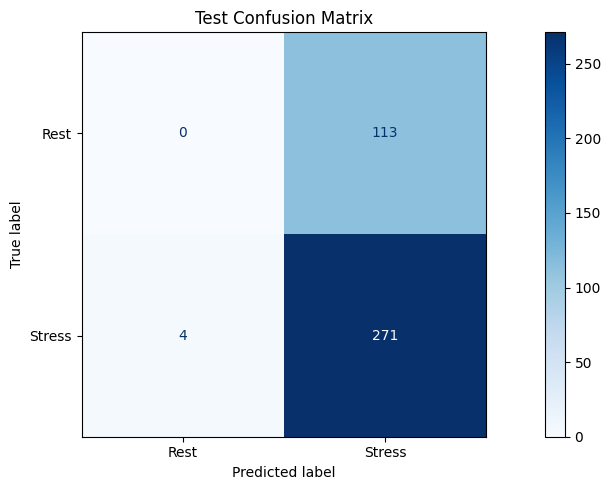

In [39]:
# Evaluate final model
loss, accuracy = final_model.evaluate(X_test, y_test)
print("Validation Accuracy:", accuracy)

# Evaluate the model on test data to get test predictions
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix for test data
test_cm = confusion_matrix(y_test, y_test_pred)
test_cmd = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)

# Plot confusion matrices
plt.figure(figsize=(12, 5))
test_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()